In [9]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

The goal here is to build and evalutate simple models based on mean meter readings (per day of week, per hour).

An important and tricky point is how are we going to split the data between train and validation.<br>
For time-serie data, usually we cannot do the usual random split, because of correlations.<br>
Usually, some kind of walk-forward approach is used.<br>
Here, we use hv-block cross validation : we keep a gap of unused data between train and validation, to avoid using correlated data between train and validation.<br>
This method has been studied and described by Racine (2000) : http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.30.6748&rep=rep1&type=pdf<br>
We used an open-source implementation that extends scikit-learn : http://www.zhengwenjie.net/tscv/<br>
See notebook 'test_tscv_lib.ipynb'

In [10]:
filepath = '../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_1176_m_0_t_20200119_132059.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8512 entries, 2016-01-02 00:00:00 to 2016-12-31 11:00:00
Data columns (total 12 columns):
day_of_week                     8512 non-null int64
day_hour                        8512 non-null int64
dew_temperature_ma_24H          8512 non-null float64
air_temperature                 8512 non-null float64
wind_speed_ma_24H               8512 non-null float64
precip_depth_1_hr_ma_24H        8512 non-null float64
sea_level_pressure_shift_10H    8512 non-null float64
meter_reading                   8512 non-null float64
meter_reading_trend             8512 non-null float64
meter_reading_seasonal          8512 non-null float64
meter_reading_deseasoned        8512 non-null float64
meter_reading_resid             8512 non-null float64
dtypes: float64(10), int64(2)
memory usage: 864.5 KB


In [11]:
df_features.head()

,day_of_week,day_hour,dew_temperature_ma_24H,air_temperature,wind_speed_ma_24H,precip_depth_1_hr_ma_24H,sea_level_pressure_shift_10H,meter_reading,meter_reading_trend,meter_reading_seasonal,meter_reading_deseasoned,meter_reading_resid
timestamp,,,,,,,,,,,,
2016-01-02 00:00:00,5,0,-10.120833,-3.3,4.737500,-0.208333,1019.4,73.866,82.076000,-26.759415,100.625415,18.549415
2016-01-02 01:00:00,5,1,-9.979167,-3.9,4.779167,-0.166667,1018.9,69.788,82.069396,-32.469222,102.257222,20.187826
2016-01-02 02:00:00,5,2,-9.887500,-5.0,4.862500,-0.125000,1017.9,68.563,82.132312,-35.705572,104.268572,22.136259
2016-01-02 03:00:00,5,3,-9.816667,-5.6,4.883333,-0.083333,1017.4,69.133,81.996854,-36.882202,106.015202,24.018348
2016-01-02 04:00:00,5,4,-9.766667,-6.1,4.862500,-0.083333,1017.1,69.085,81.552562,-37.362799,106.447799,24.895237


In [69]:
target_variables = set(['meter_reading', 'meter_reading_trend', 'meter_reading_deseasoned'])
features_variables = set(df_features.columns.to_list())-target_variables
meteorological_variables = features_variables - set(['day_hour'])
print(meteorological_variables)

{'wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H', 'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H', 'meter_reading_resid', 'dew_temperature_ma_24H'}


In [70]:
#y_meter_trend = df_features['meter_reading']
#y_meter_seasonal = df_features['meter_reading_seasonal']
#y_meter_deseasoned = df_features['meter_reading_deseasoned']
Ys_meter = df_features[target_variables]

X_meter = df_features.loc[:, meteorological_variables]
print('X_meter.shape = {}, Ys_meter.shape = {}'.format(X_meter.shape, Ys_meter.shape))

X_meter.shape = (8512, 8), Ys_meter.shape = (8512, 3)


In [71]:
X_meter.columns

Index(['wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H',
       'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H',
       'meter_reading_resid', 'dew_temperature_ma_24H'],
      dtype='object')

In [72]:
# GapKFold
# gap ~ two weeks, train = 1 month (12 folds)

gap = 24*7*2
gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)

Let's build a mean value estimator.

From https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py

check_array and check_X_y

https://github.com/scikit-learn/scikit-learn/blob/e5698bde9/sklearn/utils/validation.py#L904

In [16]:
# Actually we don't need that because it already exists in sklearn, under the name 'dummyRegressor'
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [17]:
cross_val_score(
    estimator=DummyRegressor(strategy="mean"),
    X=X_meter,
    y=y_meter,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

NameError: name 'y_meter' is not defined

In [18]:
cross_val_score(
    estimator=DummyRegressor(strategy="median"),
    X=X_meter,
    y=y_meter,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

NameError: name 'y_meter' is not defined

In [19]:
# note : this is not the RMSLE metric defined for the competition, it is not in sklearn, we must implement it.

In [20]:
# Now let's take the mean by hour

In [21]:
class MeanByCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_idx=0, verbose=False):
        self.verbose = verbose
        self.cat_column_idx= cat_column_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        if(self.cat_column_idx >= X.shape[1]):
             raise ValueError("category column index should be < X.shape[1]")
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in np.unique(X[:, self.cat_column_idx]):
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            categories[X[k, self.cat_column_idx]].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        for sample_cat in X[:, self.cat_column_idx]:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [22]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')

myEst = MeanByCatEstimator(cat_column_idx=day_hour_col_idx)

ValueError: 'day_hour' is not in list

In [23]:
myEst.fit(X_meter, y_meter)

NameError: name 'myEst' is not defined

In [24]:

X_meter.shape

(8512, 8)

In [26]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')

cross_val_score(
    estimator=MeanByCatEstimator(cat_column_idx=day_hour_col_idx),
    X=X_meter,
    y=y_meter,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

ValueError: 'day_hour' is not in list

In [27]:
class MeanByMultiCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_indexes=[0], verbose=False):
        self.verbose = verbose
        self.cat_column_indexes = cat_column_indexes

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        
        cat_columns = []
        
        for col_idx in self.cat_column_indexes:
            if(col_idx >= X.shape[1]):
                raise ValueError("category column indexes should be < X.shape[1]")
            cat_columns.append(X[:, col_idx])
            
        cat_tuples = set(zip(*cat_columns))
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in cat_tuples:
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            sample_bin = tuple(X[k, self.cat_column_indexes])
            categories[sample_bin].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        
        cat_columns=[]
        for col in self.cat_column_indexes:
            cat_columns.append(X[:, col])
            
        cat_tuples = list(zip(*cat_columns))
        
        
        
        for sample_cat in cat_tuples:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [73]:
X_meter.columns

Index(['wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H',
       'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H',
       'meter_reading_resid', 'dew_temperature_ma_24H'],
      dtype='object')

In [29]:
cross_val_score(
    estimator=MeanByMultiCatEstimator([0,1]),
    X=X_meter,
    y=y_meter,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

NameError: name 'y_meter' is not defined

In [30]:
# Let's try a linear regression

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
linReg = LinearRegression()

linReg.fit(X_meter, y_meter)

NameError: name 'y_meter' is not defined

In [ ]:
cross_val_score(
    estimator=LinearRegression(),
    X=X_meter,
    y=y_meter,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

In [33]:
# Try a k nearest-neighbours.
# We need to scale, so to use a scaler with cross-validation, we need to set a pipeline.

In [34]:
X_meter.head()

,wind_speed_ma_24H,air_temperature,sea_level_pressure_shift_10H,day_of_week,meter_reading_seasonal,precip_depth_1_hr_ma_24H,meter_reading_resid,dew_temperature_ma_24H
timestamp,,,,,,,,
2016-01-02 00:00:00,4.737500,-3.3,1019.4,5,-26.759415,-0.208333,18.549415,-10.120833
2016-01-02 01:00:00,4.779167,-3.9,1018.9,5,-32.469222,-0.166667,20.187826,-9.979167
2016-01-02 02:00:00,4.862500,-5.0,1017.9,5,-35.705572,-0.125000,22.136259,-9.887500
2016-01-02 03:00:00,4.883333,-5.6,1017.4,5,-36.882202,-0.083333,24.018348,-9.816667
2016-01-02 04:00:00,4.862500,-6.1,1017.1,5,-37.362799,-0.083333,24.895237,-9.766667


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [36]:

transformers = [('scaler', StandardScaler()), ('estimator', LinearRegression())]

my_first_pipe = Pipeline(transformers)




In [37]:
cross_val_score(my_first_pipe, X_meter, y_meter,  scoring='neg_mean_squared_log_error',
    cv=gap_kf)

NameError: name 'y_meter' is not defined

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [39]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())
cross_val_score(pipe, X_meter, y_meter, scoring='neg_mean_squared_log_error', cv=gap_kf).mean()

NameError: name 'y_meter' is not defined

In [ ]:
pipe.get_params().keys()

In [40]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

knn_grid_params = {
    'kneighborsregressor__n_neighbors' : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70],
    'kneighborsregressor__p' : [1, 2, 3, 4]
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, y_meter)

NameError: name 'y_meter' is not defined

In [41]:
knn_CV.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [42]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [44]:
Ys_meter.columns

Index(['meter_reading_deseasoned', 'meter_reading_trend', 'meter_reading'], dtype='object')

In [45]:
# Build an estimator which is the sum of an estimator + the seasonal component.






In [74]:
# TODO plus simple : faire  def __init__(self, trend_estimator, seasonal_component_col_idx)
# et mettre y_seasonal dans X

class TrendEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, trend_estimator, seasonal_component_idx, resid_idx):
        self.trend_estimator = trend_estimator
        self.seasonal_component_idx = seasonal_component_idx
        self.resid_idx = resid_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=True)
        
        self.features_idxs = list(set(range(X.shape[1])) - set([self.seasonal_component_idx, self.resid_idx]))
        
        # fit only on trend features
        X_trend = X[:, self.features_idxs]
        
        
        # Substract trend to target
        y_trend = y - X[:, self.seasonal_component_idx] - X[:, self.resid_idx]
        
        
        self.trend_estimator.fit(X_trend, y_trend)
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        
        # fit only on trend features
        X_trend = X[:, self.features_idxs]
        
        predicted_trend = self.trend_estimator.predict(X_trend)
        
        y_season = X[:, self.seasonal_component_idx]
             
        return predicted_trend + y_season

In [75]:
# time cols = [0, 5]
X_meter.columns

Index(['wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H',
       'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H',
       'meter_reading_resid', 'dew_temperature_ma_24H'],
      dtype='object')

In [76]:
trendLinReg = LinearRegression()
full_est = TrendEstimator(trendLinReg, 4, 6)

cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.038793118528045865

In [77]:
trendLinReg =  KNeighborsRegressor(n_neighbors=50, p=1)
full_est = TrendEstimator(trendLinReg, 4, 6)

cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.04494471415828624

In [51]:
trendLinReg = LinearRegression()
full_est = TrendEstimator(trendLinReg, 0, 5)

In [52]:
cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.029348270894151846

In [53]:
X_meter.columns

Index(['wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H',
       'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H',
       'meter_reading_resid', 'dew_temperature_ma_24H'],
      dtype='object')

In [54]:
trendKNR = KNeighborsRegressor()
full_est = TrendEstimator(trendKNR, 0, 5)

pipe = make_pipeline(StandardScaler(), full_est)

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'trendestimator', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'trendestimator__resid_idx', 'trendestimator__seasonal_component_idx', 'trendestimator__trend_estimator__algorithm', 'trendestimator__trend_estimator__leaf_size', 'trendestimator__trend_estimator__metric', 'trendestimator__trend_estimator__metric_params', 'trendestimator__trend_estimator__n_jobs', 'trendestimator__trend_estimator__n_neighbors', 'trendestimator__trend_estimator__p', 'trendestimator__trend_estimator__weights', 'trendestimator__trend_estimator'])

In [55]:
trendKNR = KNeighborsRegressor()
full_est = TrendEstimator(trendKNR, 0, 5)

pipe = make_pipeline(StandardScaler(), full_est)

knn_grid_params = {
    'trendestimator__trend_estimator__n_neighbors' : [20, 50, 70, 80, 90, 100],
    'trendestimator__trend_estimator__p' : [1, 2]
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, Ys_meter['meter_reading'])

GridSearchCV(cv=GapKFold(gap_after=336, gap_before=336, n_splits=12),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('trendestimator',
                                        TrendEstimator(resid_idx=5,
                                                       seasonal_component_idx=0,
                                                       trend_estimator=KNeighborsRegressor(algorithm='auto',
                                                                                           leaf_size=30,
                                                                                           met...inkowski',
                                           

In [56]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

best_params : {'trendestimator__trend_estimator__n_neighbors': 90, 'trendestimator__trend_estimator__p': 1}
best_score : -0.021342684741704532


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [58]:
trendRFR = RandomForestRegressor()
full_est = TrendEstimator(trendRFR, 0, 5)

pipe = make_pipeline(StandardScaler(), full_est)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'trendestimator', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'trendestimator__resid_idx', 'trendestimator__seasonal_component_idx', 'trendestimator__trend_estimator__bootstrap', 'trendestimator__trend_estimator__criterion', 'trendestimator__trend_estimator__max_depth', 'trendestimator__trend_estimator__max_features', 'trendestimator__trend_estimator__max_leaf_nodes', 'trendestimator__trend_estimator__min_impurity_decrease', 'trendestimator__trend_estimator__min_impurity_split', 'trendestimator__trend_estimator__min_samples_leaf', 'trendestimator__trend_estimator__min_samples_split', 'trendestimator__trend_estimator__min_weight_fraction_leaf', 'trendestimator__trend_estimator__n_estimators', 'trendestimator__trend_estimator__n_jobs', 'trendestimator__trend_estimator__oob_score', 'trendestimator__trend_estimator__random_state', 'trendestimator__trend_estimator__verbose', 'trendestimator__tren

In [59]:
trendRFR = RandomForestRegressor()
full_est = TrendEstimator(trendRFR, 0, 5)

pipe = make_pipeline(StandardScaler(), full_est)

knn_grid_params = {
    'trendestimator__trend_estimator__n_estimators' : [50, 100],
    'trendestimator__trend_estimator__max_features' : ['auto', 'sqrt']
    
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, Ys_meter['meter_reading'])

GridSearchCV(cv=GapKFold(gap_after=336, gap_before=336, n_splits=12),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('trendestimator',
                                        TrendEstimator(resid_idx=5,
                                                       seasonal_component_idx=0,
                                                       trend_estimator=RandomForestRegressor(bootstrap=True,
                                                                                             criterion='mse',...
                                                                                             n_jobs=None,
                                     

In [60]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

best_params : {'trendestimator__trend_estimator__max_features': 'auto', 'trendestimator__trend_estimator__n_estimators': 100}
best_score : -0.016242635638063423


In [78]:
trendRFR = RandomForestRegressor(n_estimators=50, max_features='sqrt')
full_est = TrendEstimator(trendRFR, 4, 6)

In [79]:
cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.040539923008313244

In [80]:
from sklearn.model_selection import cross_val_predict

In [82]:
preds = cross_val_predict(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    cv=gap_kf)

In [83]:
preds.shape

(8512,)

In [92]:
preds_df = pd.DataFrame(index=X_meter.index)
preds_df['predictions'] = preds
preds_df['target'] = Ys_meter['meter_reading']

In [93]:
preds_df.head()

,predictions,target
timestamp,,
2016-01-02 00:00:00,71.153860,73.866
2016-01-02 01:00:00,65.639332,69.788
2016-01-02 02:00:00,61.461880,68.563
2016-01-02 03:00:00,60.110365,69.133
2016-01-02 04:00:00,59.629768,69.085


In [96]:
preds_df_melt = pd.melt(preds_df.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
preds_df_melt.head()

,timestamp,component,reading
0,2016-01-02 00:00:00,predictions,71.153860
1,2016-01-02 01:00:00,predictions,65.639332
2,2016-01-02 02:00:00,predictions,61.461880
3,2016-01-02 03:00:00,predictions,60.110365
4,2016-01-02 04:00:00,predictions,59.629768


In [94]:
import seaborn as sns

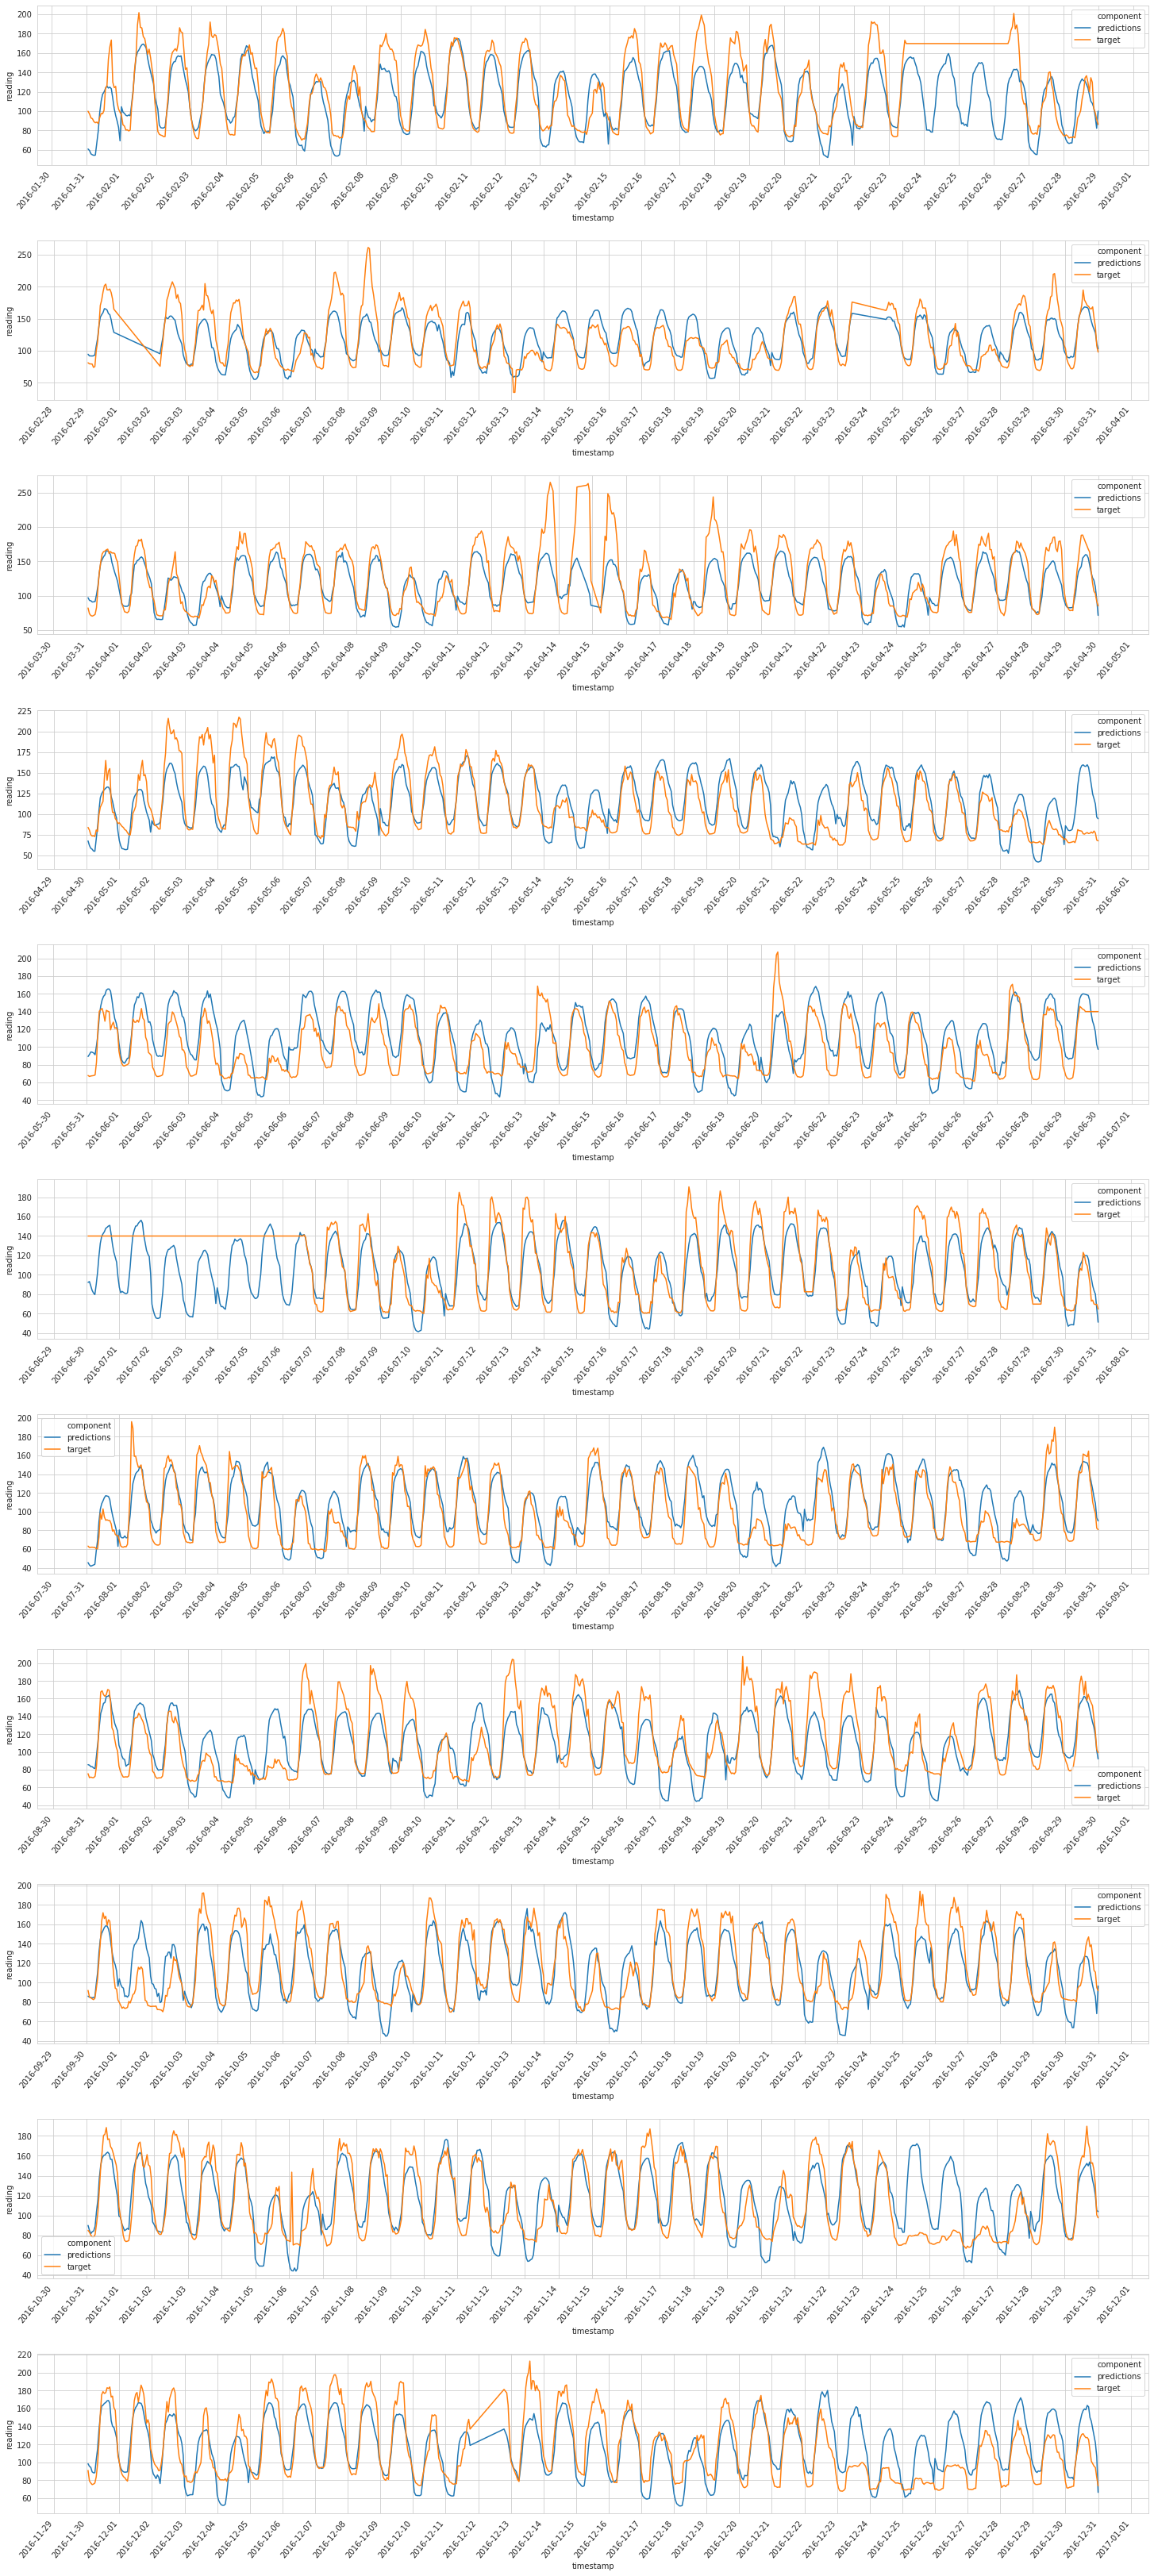

In [99]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

In [101]:
X_meter.columns

Index(['wind_speed_ma_24H', 'air_temperature', 'sea_level_pressure_shift_10H',
       'day_of_week', 'meter_reading_seasonal', 'precip_depth_1_hr_ma_24H',
       'meter_reading_resid', 'dew_temperature_ma_24H'],
      dtype='object')

In [103]:
preds_df_2 = pd.DataFrame(index=X_meter.index)
preds_df_2['trend_predictions'] = preds - X_meter['meter_reading_seasonal']
preds_df_2['meter_reading'] = Ys_meter['meter_reading']
preds_df_2['trend_target'] = Ys_meter['meter_reading_trend']
preds_df_2['meter_deseasoned'] = Ys_meter['meter_reading_deseasoned']

In [104]:
preds_df_2_melt = pd.melt(preds_df_2.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
preds_df_2_melt.head()

,timestamp,component,reading
0,2016-01-02 00:00:00,trend_predictions,97.913275
1,2016-01-02 01:00:00,trend_predictions,98.108554
2,2016-01-02 02:00:00,trend_predictions,97.167452
3,2016-01-02 03:00:00,trend_predictions,96.992567
4,2016-01-02 04:00:00,trend_predictions,96.992567


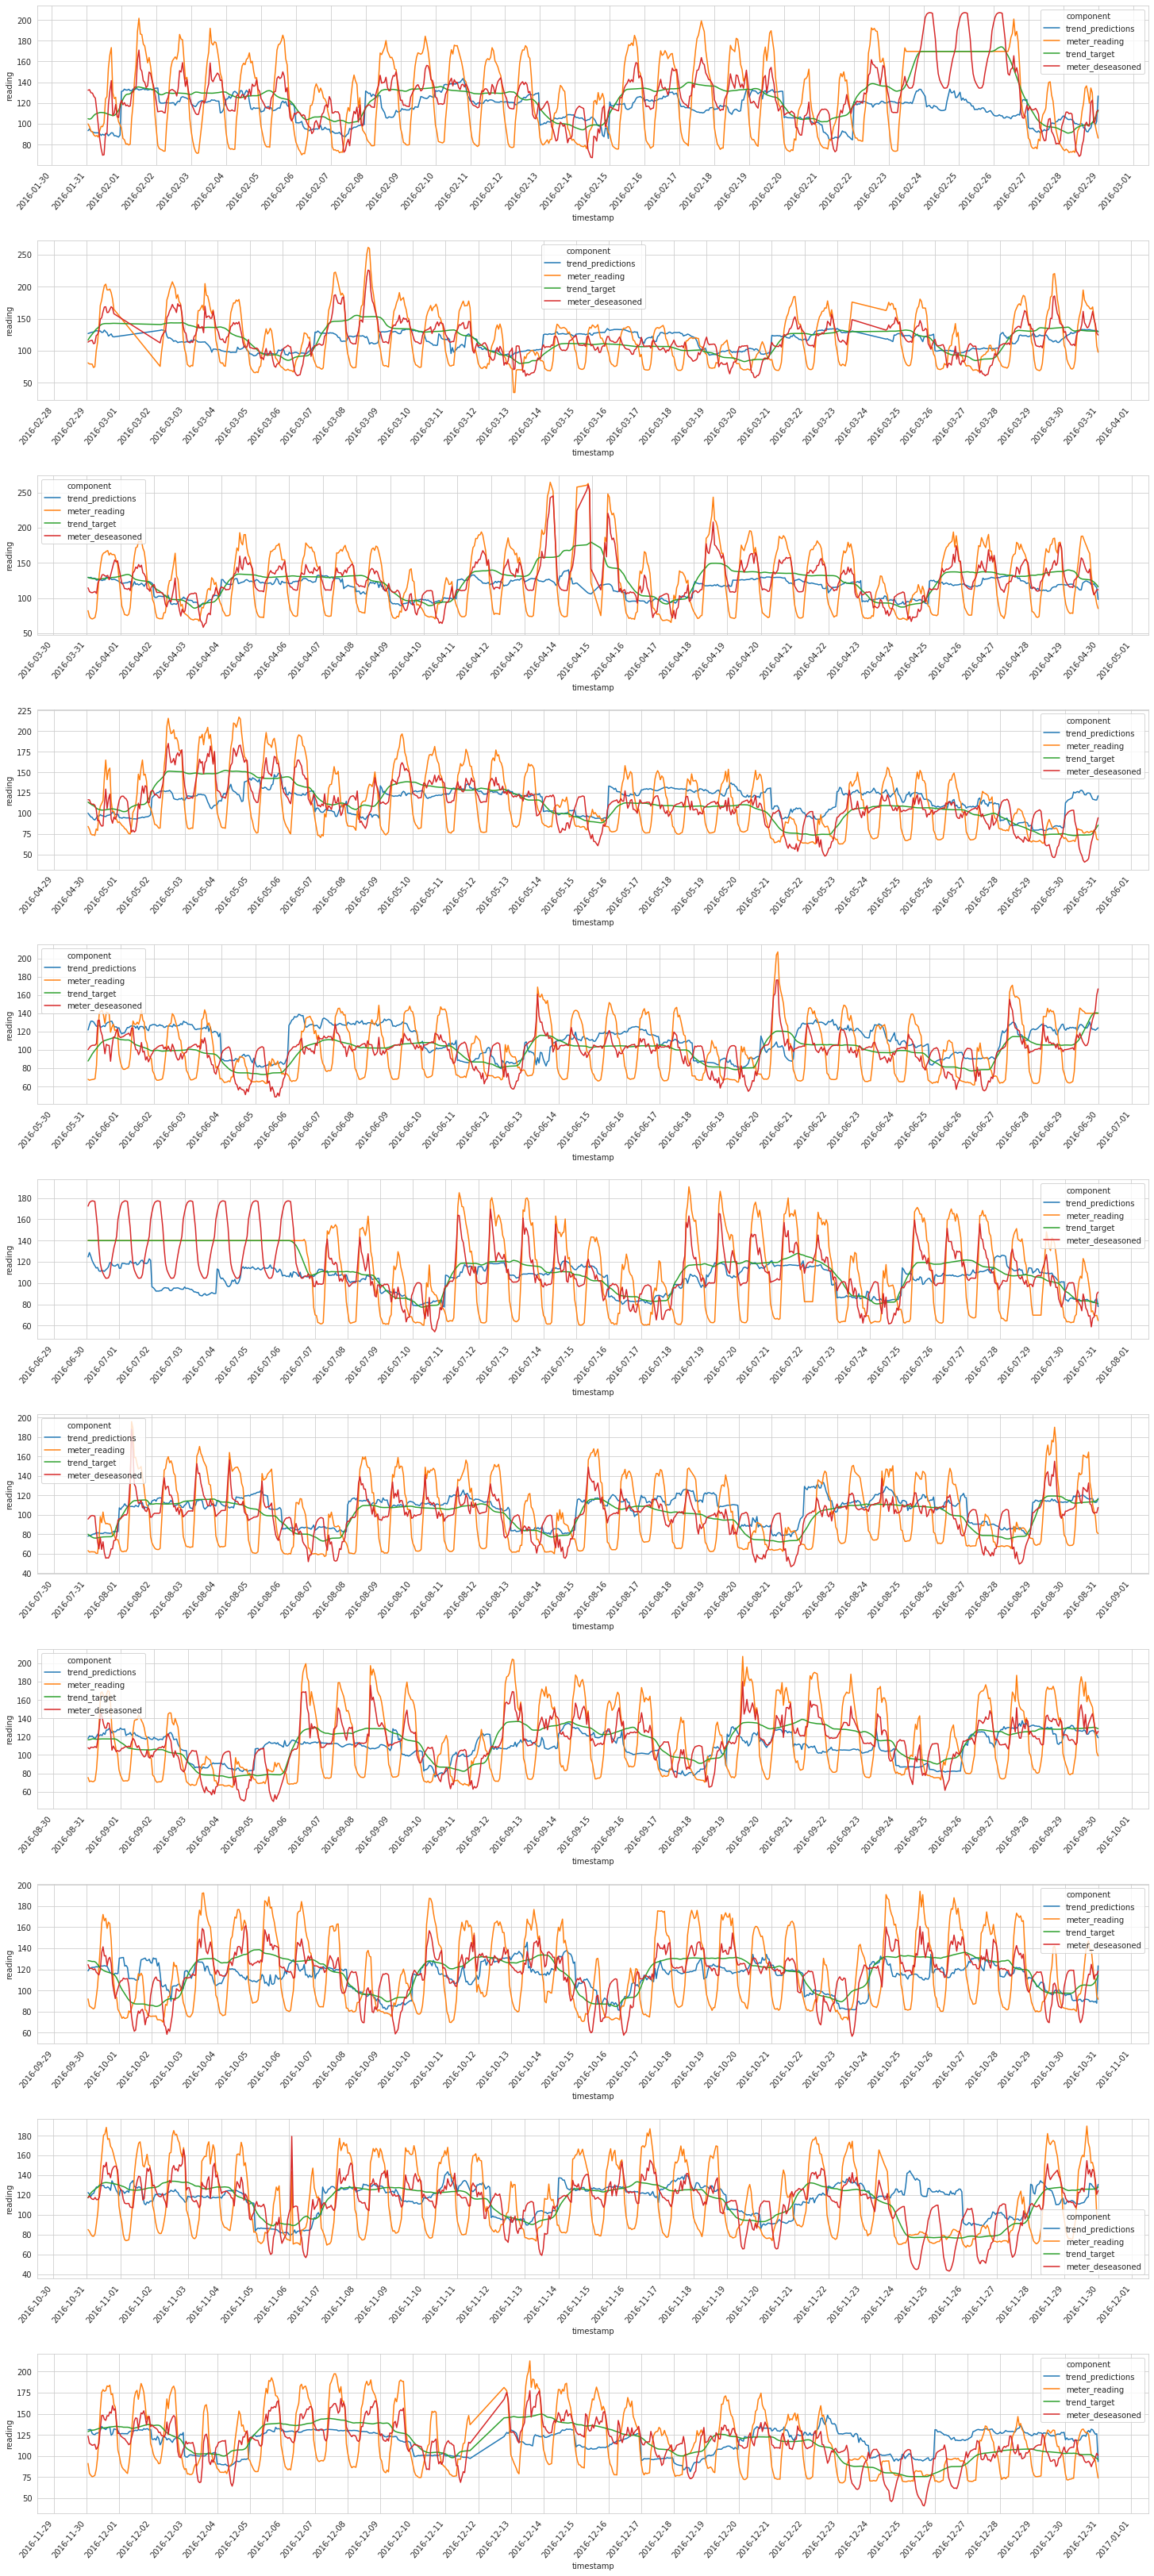

In [105]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_2_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    